In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import seaborn as sns

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
from crycompare import *

### Get list of all coins

In [4]:
p = Price()

coinList = p.coinList()
coins = sorted(list( coinList['Data'].keys() ))
coins[:5]

['007', '1337', '1CR', '1ST', '2015']

In [5]:
# coins_to_check = ['BTC', 'ETH', 'LTC', 'ARK']
coins_to_check = ['BTC', 'ETH', 'LTC', 'ARK', 'XMR']
[x in coins for x in coins_to_check]

[True, True, True, True, True]

### Get historical price data

In [6]:
h = History()

df_dict = {}
for coin in coins_to_check:
    histo = h.histoDay(coin,'USD',allData=True)
    if histo['Data']:
        df_histo = pd.DataFrame(histo['Data'])
        df_histo['time'] = pd.to_datetime(df_histo['time'],unit='s')
        df_histo.index = df_histo['time']
        del df_histo['time']
        del df_histo['volumefrom']
        del df_histo['volumeto']
        
        df_dict[coin] = df_histo

In [7]:
df = pd.DataFrame()
df['BTC'] = df_dict['BTC']['close']
for key, value in df_dict.items():
    if key == 'BTC':
        continue
    df[key] = value['close']

df.fillna(value=0, inplace=True)
df.tail()

,BTC,ETH,LTC,XMR
time,,,,
2017-10-22,5982.86,294.03,56.51,86.51
2017-10-23,5903.61,285.27,54.63,85.17
2017-10-24,5513.08,296.50,55.56,88.03
2017-10-25,5734.00,296.35,56.19,87.08
2017-10-26,5929.85,297.00,56.24,88.02


In [8]:
df_log = pd.DataFrame()
for coin in df.columns:
    df_log[coin] = np.diff(np.log(df[coin]))
    df_log[coin].replace(-np.Inf, 0, inplace=True)
    df_log[coin].replace(np.Inf, 0, inplace=True)

df_log.index = df.index[1:]
# df_log.fillna(value=0, inplace=True)
df_log.tail()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:1768: RuntimeWarning: invalid value encountered in subtract
  return a[slice1]-a[slice2]


,BTC,ETH,LTC,XMR
time,,,,
2017-10-22,-0.003968,-0.018600,-0.027576,-0.017531
2017-10-23,-0.013335,-0.030246,-0.033834,-0.015611
2017-10-24,-0.068441,0.038611,0.016880,0.033028
2017-10-25,0.039290,-0.000506,0.011275,-0.010850
2017-10-26,0.033586,0.002191,0.000889,0.010737


### Plot log returns

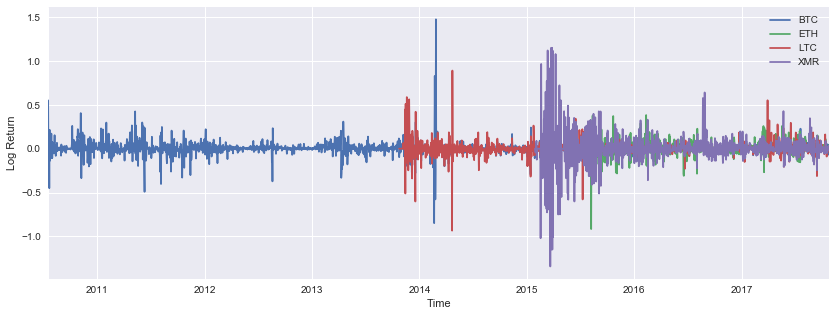

In [9]:
df_log.plot(figsize=(14,5))
plt.xlabel('Time')
plt.ylabel('Log Return')

### ADF Test to ensure stationarity
p <= 0.05, reject null, the data doesn't have unit root and is stationary.

In [10]:
for col in df_log:
    result = adfuller(df_log[col].dropna())
    print('{}:'.format(col))
    print('\tADF Statistic: %f' % result[0])
    print('\tp-value: %f' % result[1])
    print('\tCritical Values:')
    for key, value in result[4].items():
        print('\t\t%s: %.3f' % (key, value))

BTC:
	ADF Statistic: -20.460087
	p-value: 0.000000
	Critical Values:
		1%: -3.433
		5%: -2.863
		10%: -2.567
ETH:
	ADF Statistic: -16.377641
	p-value: 0.000000
	Critical Values:
		1%: -3.438
		5%: -2.865
		10%: -2.569
LTC:
	ADF Statistic: -12.710245
	p-value: 0.000000
	Critical Values:
		1%: -3.435
		5%: -2.864
		10%: -2.568
XMR:
	ADF Statistic: -8.632810
	p-value: 0.000000
	Critical Values:
		1%: -3.437
		5%: -2.864
		10%: -2.568


BTC acf mean: BTC    0.006021
dtype: float64
ETH acf mean: ETH    0.008801
dtype: float64
LTC acf mean: LTC    0.002345
dtype: float64
XMR acf mean: XMR   -0.010515
dtype: float64


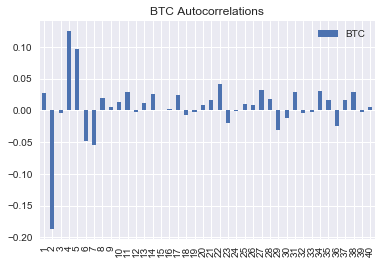

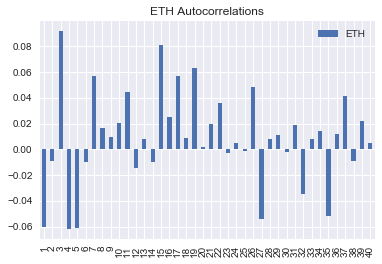

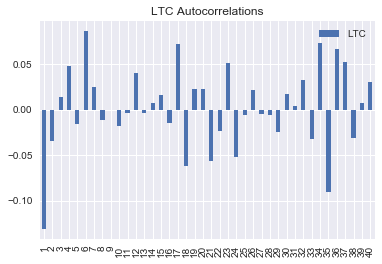

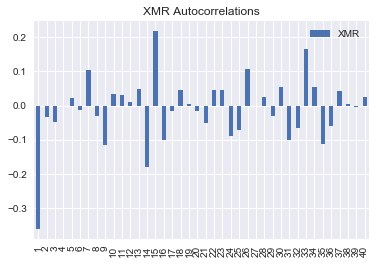

In [11]:
for col in df_log.columns:
    acf = pd.DataFrame(sm.tsa.stattools.acf(df_log[col].dropna()), columns=[col])
    fig = acf[1:].plot(kind='bar', title='{} Autocorrelations'.format(col))
    print('{} acf mean: {}'.format(col, acf[1:].mean()))

All stationary, so good.

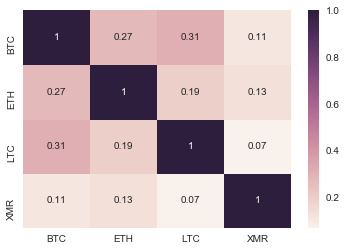

In [12]:
corr_mtx = df_log.corr()
sns.heatmap(corr_mtx,annot=True)

In [13]:
df_log.dropna().head().replace(np.inf, 0)

,BTC,ETH,LTC,XMR
time,,,,
2015-08-07,-0.000396,0.000000,0.022196,0.158605
2015-08-08,-0.071943,-0.916291,-0.083912,0.000000
2015-08-09,0.020174,0.000000,0.026180,0.000000
2015-08-10,-0.002162,0.000000,0.002581,-0.411684
2015-08-11,0.021529,-0.192372,0.050262,0.000000


In [14]:
df_log.dropna().tail().replace(np.inf, 0)

,BTC,ETH,LTC,XMR
time,,,,
2017-10-22,-0.003968,-0.018600,-0.027576,-0.017531
2017-10-23,-0.013335,-0.030246,-0.033834,-0.015611
2017-10-24,-0.068441,0.038611,0.016880,0.033028
2017-10-25,0.039290,-0.000506,0.011275,-0.010850
2017-10-26,0.033586,0.002191,0.000889,0.010737


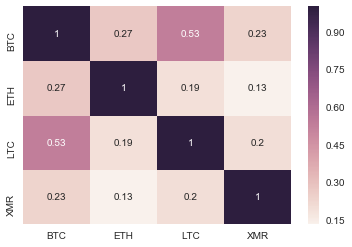

In [15]:
corr_mtx = df_log.dropna().replace(np.inf, 0).corr()
sns.heatmap(corr_mtx,annot=True)

## Momentum strategy

In [102]:
df.head()

,BTC,LTC,ARK,XMR,ETH
time,,,,,
2010-07-17,0.04951,0.0,0.0,0.0,0.0
2010-07-18,0.08584,0.0,0.0,0.0,0.0
2010-07-19,0.08080,0.0,0.0,0.0,0.0
2010-07-20,0.07474,0.0,0.0,0.0,0.0
2010-07-21,0.07921,0.0,0.0,0.0,0.0


In [103]:
df['BTC'].shift(1).head()

time
2010-07-17        NaN
2010-07-18    0.04951
2010-07-19    0.08584
2010-07-20    0.08080
2010-07-21    0.07474
Name: BTC, dtype: float64

In [104]:
(df['BTC'] / df['BTC'].shift(1)).head()

time
2010-07-17         NaN
2010-07-18    1.733791
2010-07-19    0.941286
2010-07-20    0.925000
2010-07-21    1.059807
Name: BTC, dtype: float64

In [105]:
cols = df.columns
for col in df.columns:
    ret_col = '{}_returns'.format(col)
    df[ret_col] = np.log(df[col] / df[col].shift(1))
    
df.head()

,BTC,LTC,ARK,XMR,ETH,BTC_returns,LTC_returns,ARK_returns,XMR_returns,ETH_returns
time,,,,,,,,,,
2010-07-17,0.04951,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2010-07-18,0.08584,0.0,0.0,0.0,0.0,0.550310,NaN,NaN,NaN,NaN
2010-07-19,0.08080,0.0,0.0,0.0,0.0,-0.060508,NaN,NaN,NaN,NaN
2010-07-20,0.07474,0.0,0.0,0.0,0.0,-0.077962,NaN,NaN,NaN,NaN
2010-07-21,0.07921,0.0,0.0,0.0,0.0,0.058087,NaN,NaN,NaN,NaN


In [106]:
mom_array = [15, 30, 60, 120]

for col in cols: 
    for momentum in mom_array:
        pos_col = '{}_position_{}'.format(col, momentum)
        df[pos_col] = np.sign(df['{}_returns'.format(col)].rolling(window=momentum).mean())
    
df.tail()

,BTC,LTC,ARK,XMR,ETH,BTC_returns,LTC_returns,ARK_returns,XMR_returns,ETH_returns,...,ARK_position_60,ARK_position_120,XMR_position_15,XMR_position_30,XMR_position_60,XMR_position_120,ETH_position_15,ETH_position_30,ETH_position_60,ETH_position_120
time,,,,,,,,,,,,,,,,,,,,,
2017-09-16,3698.92,52.10,3.58,96.40,254.49,-0.004004,0.001921,-0.095818,-0.036764,-0.019765,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0
2017-09-17,3689.61,51.00,3.30,93.72,258.40,-0.002520,-0.021339,-0.081440,-0.028195,0.015247,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0
2017-09-18,4100.28,56.16,3.70,101.74,297.53,0.105535,0.096379,0.114410,0.082109,0.141006,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
2017-09-19,3907.96,52.80,3.24,98.28,283.00,-0.048040,-0.061694,-0.132759,-0.034600,-0.050068,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0
2017-09-20,3923.45,52.55,3.29,96.53,284.08,0.003956,-0.004746,0.015314,-0.017967,0.003809,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0


,BTC,LTC,ARK,XMR,ETH,BTC_returns,LTC_returns,ARK_returns,XMR_returns,ETH_returns,...,ARK_strategy_60,ARK_strategy_120,XMR_strategy_15,XMR_strategy_30,XMR_strategy_60,XMR_strategy_120,ETH_strategy_15,ETH_strategy_30,ETH_strategy_60,ETH_strategy_120
time,,,,,,,,,,,,,,,,,,,,,
2017-09-16,3698.92,52.10,3.58,96.40,254.49,-0.004004,0.001921,-0.095818,-0.036764,-0.019765,...,-0.095818,-0.095818,0.036764,-0.036764,-0.036764,-0.036764,0.019765,0.019765,-0.019765,-0.019765
2017-09-17,3689.61,51.00,3.30,93.72,258.40,-0.002520,-0.021339,-0.081440,-0.028195,0.015247,...,-0.081440,-0.081440,0.028195,-0.028195,-0.028195,-0.028195,-0.015247,-0.015247,0.015247,0.015247
2017-09-18,4100.28,56.16,3.70,101.74,297.53,0.105535,0.096379,0.114410,0.082109,0.141006,...,0.114410,0.114410,-0.082109,0.082109,0.082109,0.082109,-0.141006,-0.141006,0.141006,0.141006
2017-09-19,3907.96,52.80,3.24,98.28,283.00,-0.048040,-0.061694,-0.132759,-0.034600,-0.050068,...,-0.132759,-0.132759,0.034600,-0.034600,-0.034600,-0.034600,0.050068,-0.050068,-0.050068,-0.050068
2017-09-20,3923.45,52.55,3.29,96.53,284.08,0.003956,-0.004746,0.015314,-0.017967,0.003809,...,0.015314,0.015314,0.017967,-0.017967,-0.017967,-0.017967,-0.003809,-0.003809,0.003809,0.003809


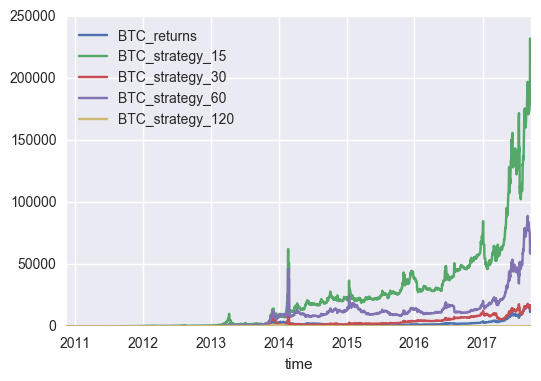

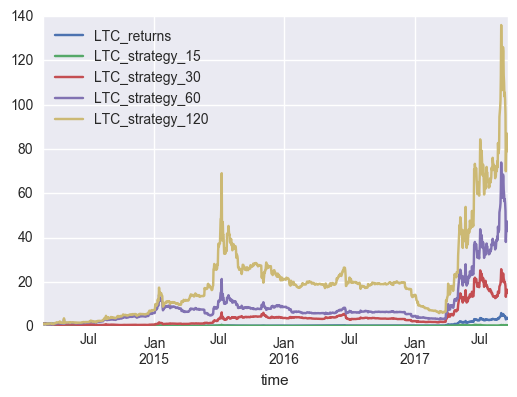

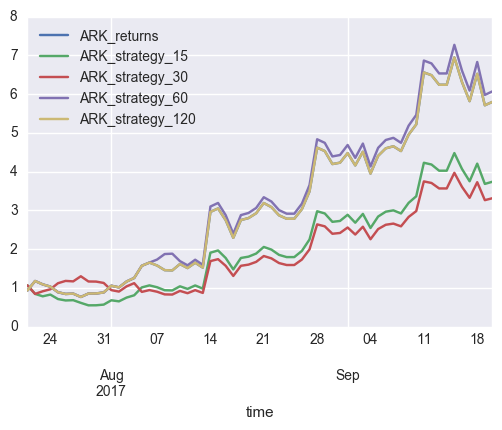

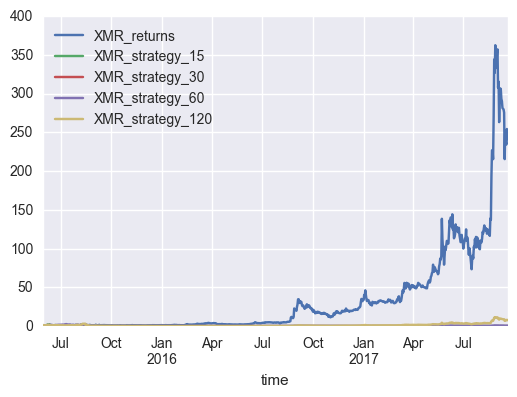

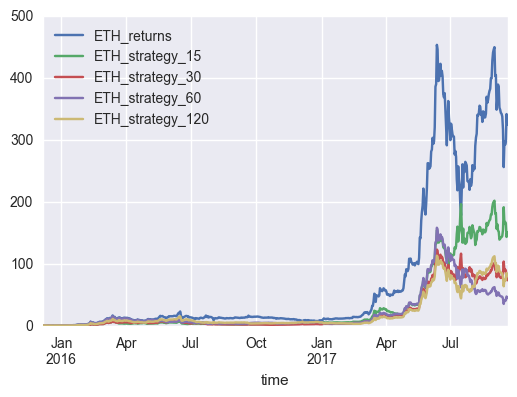

In [108]:
for col in cols:
    strats = ['{}_returns'.format(col)]
    for mom in mom_array:
        strat = '{}_strategy_{}'.format(col, mom)
        df[strat] = df['{}_position_{}'.format(col, mom)].shift(1) * df['{}_returns'.format(col)]
        strats.append(strat)

    # apply np.exp to convert logs to arithmetic returns
    df[strats].dropna().cumsum().apply(np.exp).plot()
    
df.tail()

- BTC gets big bump from momentum over returns, with best at 15 day.
- LTC momentum outperforms, with best at 120 day. Makes sense since LTC is slowest moving among the coins.
- ARK has such little price data, hard to make strong conclusions.
- XMR momentum is garbage.
- ETH returns alone perform better, but the 15 day strategy does well to avoid the large drawdown recently